In [1]:
! pip install numpy
! pip install scipy
! pip install matplotlib

In [2]:
# Importacionnes
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [3]:
def normalize_min_max(matrix):
    """
    Metodo para normalizar los datos
    Recibe: Matriz de datos original
    Entrega: Matriz de datos normalizados
    """
    max_values = np.max(matrix, axis=0)
    min_values = np.min(matrix, axis=0)

    # Lleva los datos al hiperplano (0, 1) utilizando la normalización min-max
    normalized_data = (matrix - min_values) / (max_values - min_values)
    return normalized_data

def plot_gradiente(deltas,neuronas_por_capa):
    """
    Metodo que grafica los gradientes
    Recibe: 
        1. Los deltas de todas las neuronas de todas las capas en cada epoc
        2. Numero de neuronas por capa
    Entrega: 
        1. Lista de todos los gradientes por capa
    
    """
    lista1 = []
    for i in range(len(deltas[0])):
        l2 = []
        for j in range(len(deltas)):
            l2.append(deltas[j][i])
        lista1.append(l2)

    l3 = []
    for i in lista1:
        l3.append(np.concatenate(i, axis=1))

    fig, axes = plt.subplots(nrows=1, ncols=np.sum(neuronas_por_capa), figsize=(25, 4))

    cont= 0
    for i in range(len(l3)):
        for j in range(len(l3[i])):
            axes[cont].plot(l3[i][j])
            axes[cont].set_title('$\delta$ Capa {} Neurona {}'.format(i+1,j+1))
            axes[cont].set_xlabel("Datos")
            axes[cont].set_ylabel("gradiente")
            cont+=1

    return l3

def plotAverageDeltas(l3):
    """
    Metodo que grafica el promedio de los gradientes por capa
    Recibe:
        1. Lista de todos los gradientes por capa
    """
    promedios_deltas = []
    for i in l3:
        promedios_deltas.append(np.mean(i, axis=0))
    fig, axes = plt.subplots(nrows=1, ncols=len(l3), figsize=(25, 4))

    cont= 0
    for i in range(len(promedios_deltas)):
        axes[i].plot(promedios_deltas[i])
        axes[cont].set_title('Promedios $\delta$ Capa {}'.format(i+1))
        axes[cont].set_xlabel("Datos")
        axes[cont].set_ylabel("gradiente")

class MultilayerPerceptron:
    """
        Clase del multilayer perceptron
    """
    def __init__(self,n_neuronas,funciones_activacion):
        """
            Se inicializan todas las variables del objeto
            Recibe:
                1. n_neuronas: lista de numero de neuronas por capa
                2. funciones_activacion: funcion de activacion por capa
        """
        self.n=n_neuronas[0]
        self.n_capas = len(n_neuronas)
        self.n_neuronas = n_neuronas
        self.funciones_activacion = funciones_activacion
        self.nueva_lista = np.insert(self.n_neuronas, 0, self.n)
        self.pesos = [
            [
                [np.random.rand() for j in range(self.nueva_lista[i])]
                for k in range(self.nueva_lista[i+1])
            ]
            for i in range(self.n_capas)
        ]

    def activationFunction(self,funcion,v,a=1,b=0):
        """
            Metodo que retorna la funcion de activacion de un campo
            Recibe: 
                1. funcion: que funcion de activacion se va a aplicar
                2. v: campo
            Retorna: 
                1: la funcion de activacion aplicada al campo
        """
        if funcion=="tanh": return np.tanh(a*v)
        elif funcion=="sigmoid": return 1/(1+np.exp(-(a*v)))
        else: return a*v+b

    def derivativeActivationFunction(self,funcion,v,a=1,b=0):
        """
            Metodo que retorna la derivada de la funcion de activacion de un campo
            Recibe: 
                1. funcion: que funcion de activacion se va a aplicar
                2. v: campo
            Retorna: 
                1: la derivada de la funcion de activacion aplicada al campo
        """
        if funcion=="tanh": return a*(1-np.tanh(a*v)**2)
        elif funcion=="sigmoid": return a*(np.exp(-a*v)/((1+np.exp(-a*v))**2))
        else: return a*np.ones(v.shape)
    
    def forward(self, entrada,pesos=None):
        """
            Metodo que realiza el forrward del perceptron 
            Recibe: 
                1. entradas: el punto con el que se va a realizar el forward
                2. pesos=None: los pesos con los que se va a realizar el forward
            Entrega:
                1. arreglo de salidas de la ultima capa 
                2. funcion de activacion aplicado a cada campo
                3. derivada de la funcion de activacion aplicada a cada campo
        """
        phis = [entrada]
        phis_derivada = []

        if not pesos:
            pesos= self.pesos

        vi = np.dot(pesos[0],entrada)
        resultados = self.activationFunction(self.funciones_activacion[0],vi)
        phi_primei = self.derivativeActivationFunction(self.funciones_activacion[0],vi)

        phis.append(resultados)
        phis_derivada.append(phi_primei)
        
        for i in range(1,self.n_capas):
            vj = np.dot(pesos[i],resultados)
            resultados = self.activationFunction(self.funciones_activacion[i],vj)
            phi_prime = self.derivativeActivationFunction(self.funciones_activacion[i],vj)
            phis.append(resultados)
            phis_derivada.append(phi_prime)
        return [i[0] for i in resultados], phis, phis_derivada

    def backpropagation(self,yd, entrada, learning_rate):
        """ 
            Metodo que realizar el backpropagation del perceptron
            Recibe: 
                1. yd: salida de la capa ocultta del punto
                2. entrada: el punto con el que se va a hacer el backpropagation
                3. learning_rate: el eta (tasa de aprendizaje)
            Entrega: 
                1. la matriz de pesos actualizada
                2. deltas de cada neurona por capa
        """
        entrada= np.array([[entrada[i]] for i in range(self.n)])
        out, phis, phis_prime = self.forward(entrada)

        deltas = [np.zeros(i) for i in self.n_neuronas]
        delta_k = -np.sum(yd-out)*phis_prime[-1]

        ## guardado de los deltas
        deltas[-1][:] = [i[0] for i in delta_k]

        self.pesos[-1] -= learning_rate*np.dot(delta_k,phis[-2].T)

        for i in range(1,self.n_capas):
            delta_k = np.multiply(phis_prime[-(i+1)],np.dot(np.array(self.pesos[-i]).T,delta_k))
            deltas[-(i+1)][:] = [j[0] for j in delta_k]
            self.pesos[-(i+1)] -= learning_rate*np.dot(delta_k,phis[-(i+2)].T)
    
        return self.pesos, deltas

    def epochs(self,data_n,yd,learning_rate, n_epochs):
        """ 
            Metodo que realizar el backpropagation para todos los puntos por epocs
            Recibe: 
                1. data: la matriz de datos
                2. yd: el y deseado del modelo
                3. learning_rate: el eta (tasa de aprendizaje)
                4: n_epochs: numero de epocs a realizar
            Retorna: 
                1. pesos actualizados del ultimo epoc
                2. deltas de cada neurona por capa por numero de epocs
        """
        deltas_epochs = []
        for w in range(n_epochs):
            deltas_epoch = [np.zeros((i,data_n.shape[0])) for i in self.n_neuronas]
            for i in range(len(data_n)):
                self.pesos, deltas = self.backpropagation(yd[i],data_n[i],learning_rate)
                for j in range(self.n_capas):
                    deltas_epoch[j][:,i] = deltas[j]
            deltas_epochs.append(deltas_epoch)

        return self.pesos, deltas_epochs

data = loadmat('datosIA.mat')
data_combined = np.concatenate((data['X'], data['OD'], data['S']), axis=1)
normalized_data = normalize_min_max(data_combined)

# Perceptron con una capa oculta de 2 neuronas

## Para $\eta$=1

### Escenario 1: Datos originales

In [4]:
neuronas_por_capa = [len(data_combined[0,0:2]),2,1]
instance = MultilayerPerceptron(neuronas_por_capa,["lineal","tanh","sigmoid"])
pesos, deltas= instance.epochs(data_combined[:,[0,1]],data_combined[:,2],1,1)

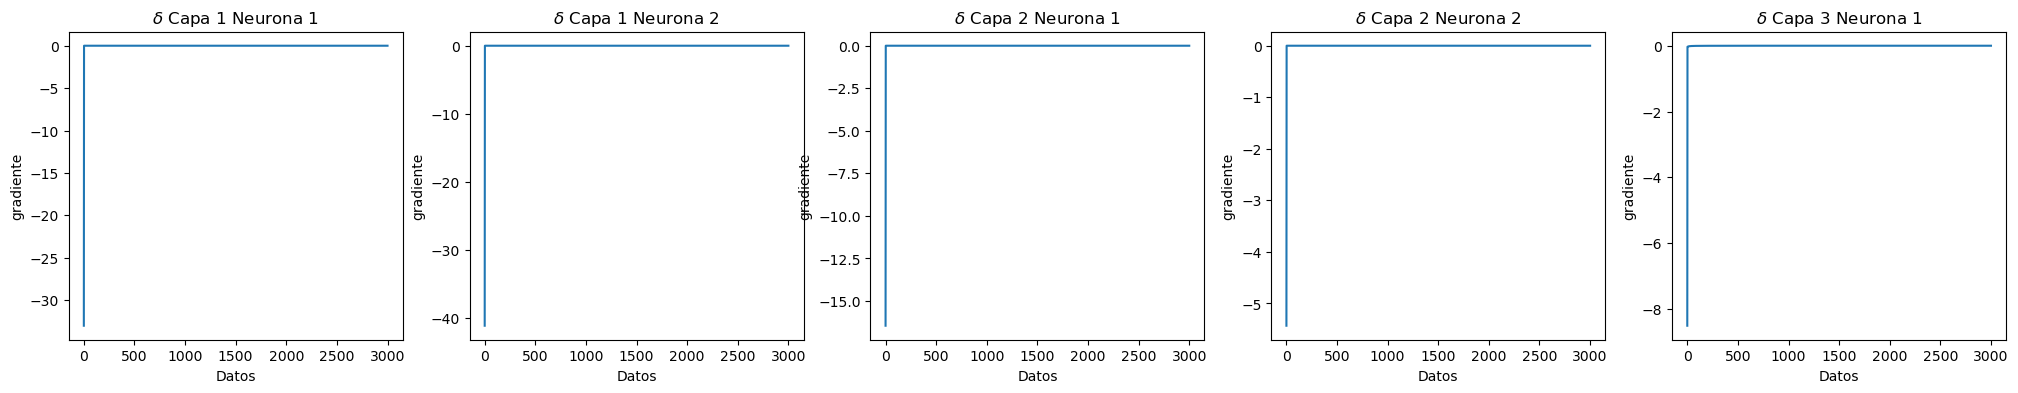

In [5]:
l3 = plot_gradiente(deltas,neuronas_por_capa)

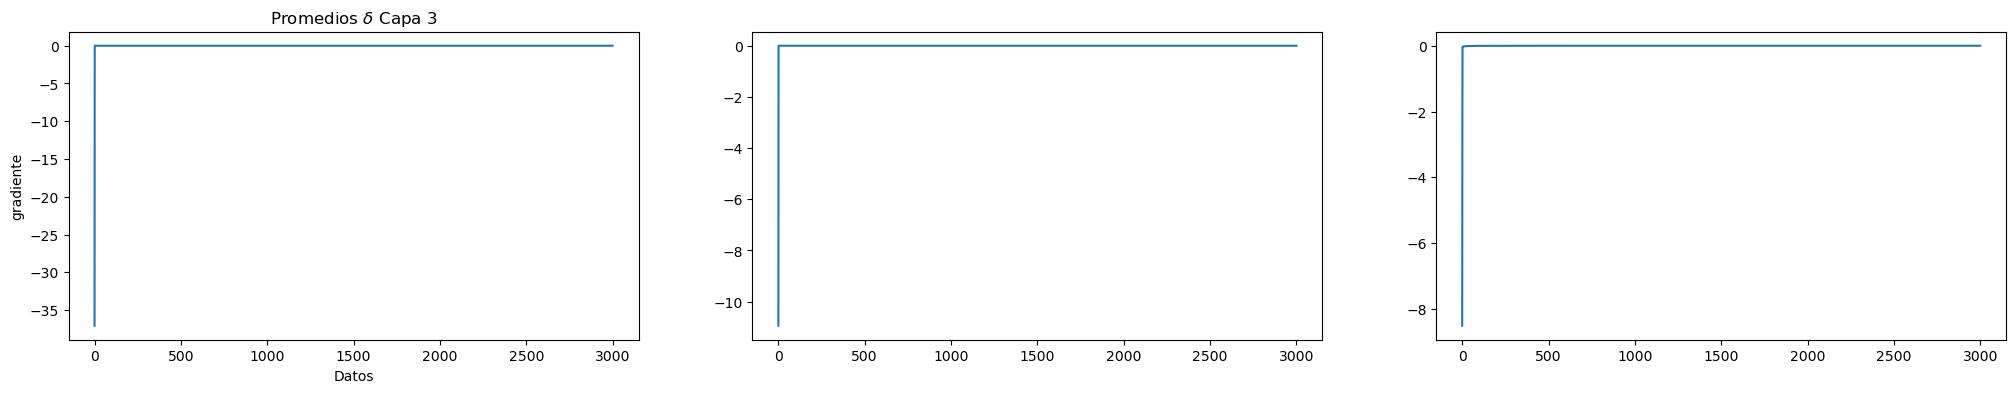

In [6]:
plotAverageDeltas(l3)

### Escenario 2: Datos normalizados

In [7]:
neuronas_por_capa = [len(data_combined[0,0:2]),2,1]
instance = MultilayerPerceptron(neuronas_por_capa,["lineal","tanh","sigmoid"])
pesos, deltas= instance.epochs(normalized_data[:,[0,1]],normalized_data[:,2],1,1)

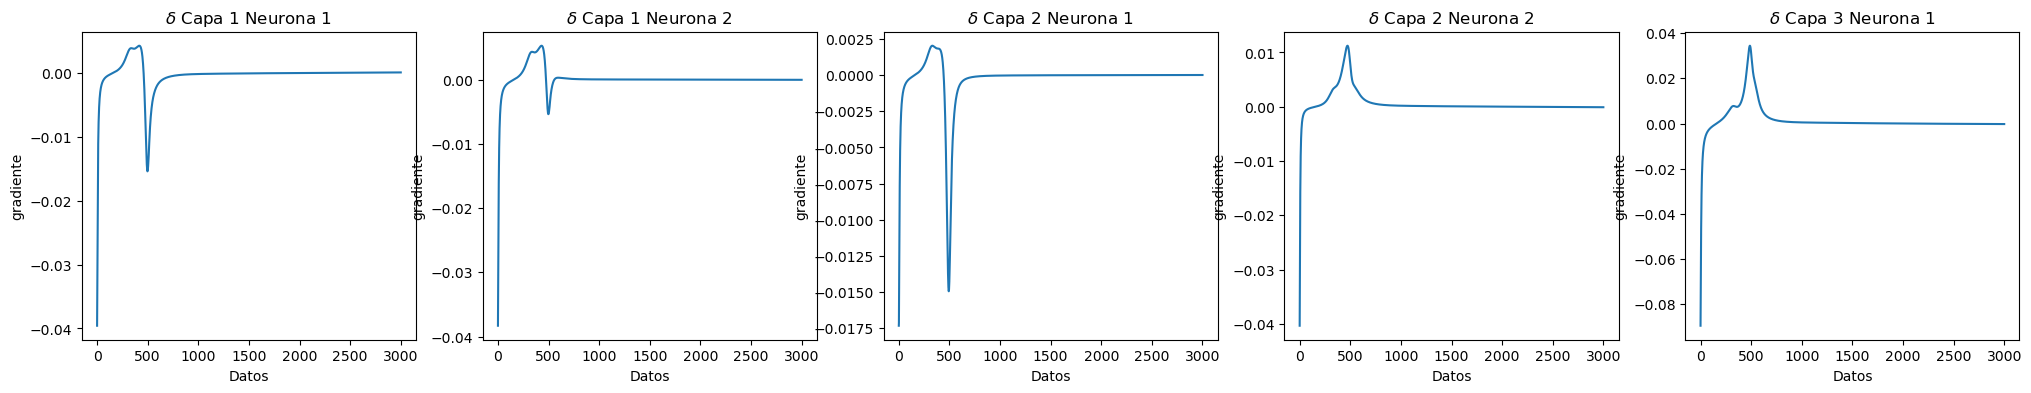

In [8]:
l3 = plot_gradiente(deltas,neuronas_por_capa)

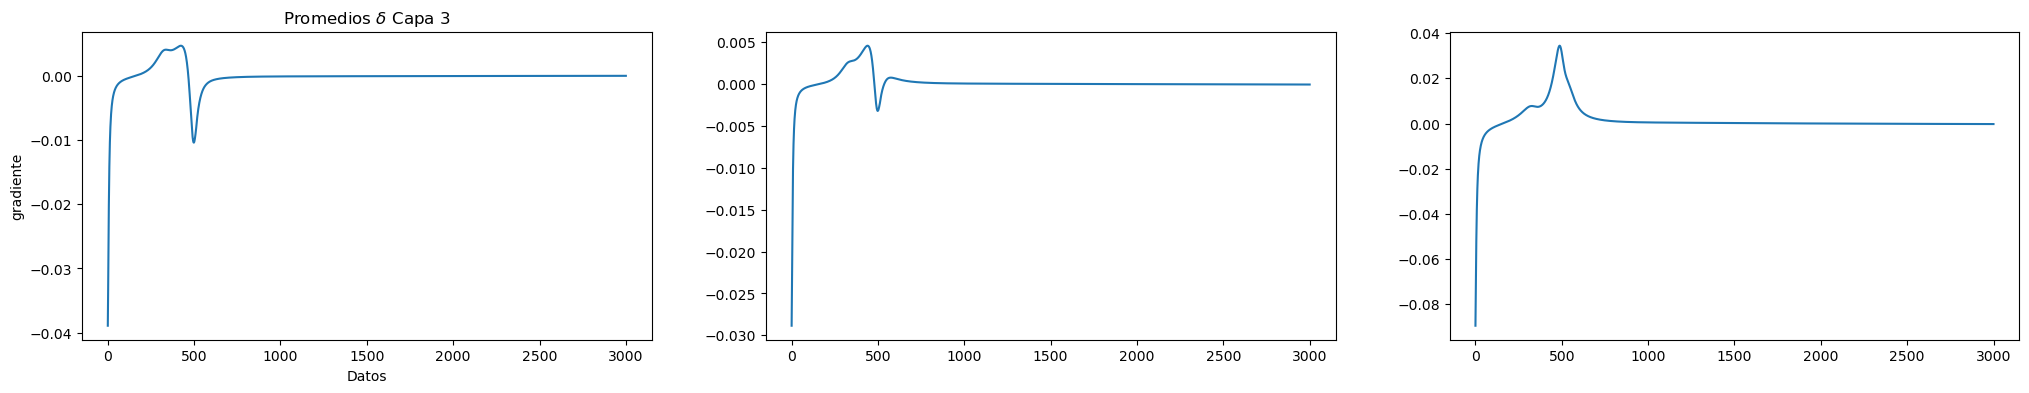

In [9]:
plotAverageDeltas(l3)

## Para $\eta$=0.5

Escenario 1: Datos originales

In [10]:
neuronas_por_capa = [len(data_combined[0,0:2]),2,1]
instance = MultilayerPerceptron(neuronas_por_capa,["lineal","tanh","sigmoid"])
pesos, deltas= instance.epochs(data_combined[:,[0,1]],data_combined[:,2],0.5,1)

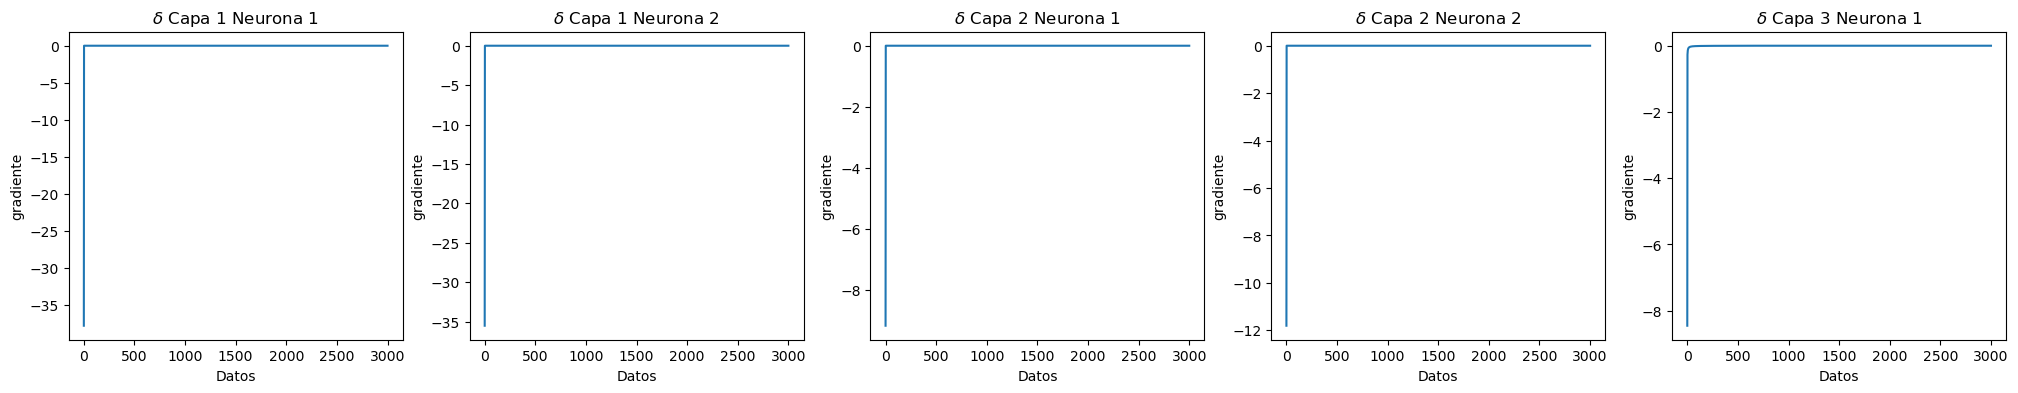

In [11]:
l3 = plot_gradiente(deltas,neuronas_por_capa)

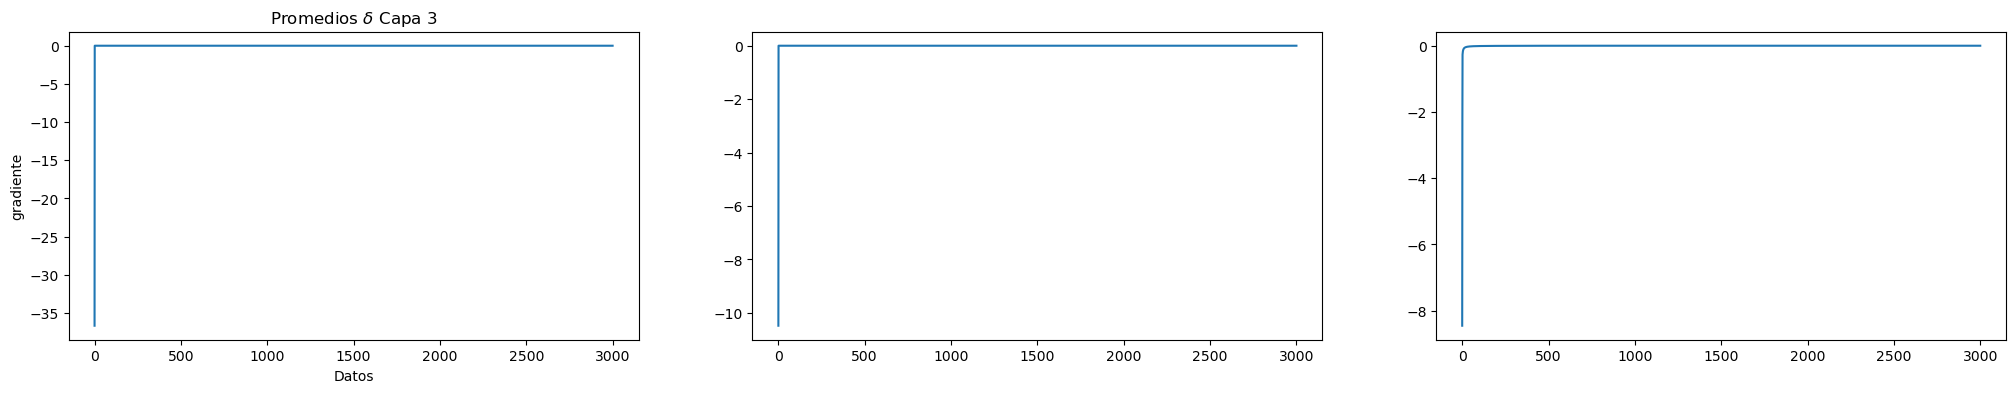

In [12]:
plotAverageDeltas(l3)

Escenario 2: Datos normalizados

In [13]:
neuronas_por_capa = [len(data_combined[0,0:2]),2,1]
instance = MultilayerPerceptron(neuronas_por_capa,["lineal","tanh","sigmoid"])
pesos, deltas= instance.epochs(normalized_data[:,[0,1]],normalized_data[:,2],0.5,1)

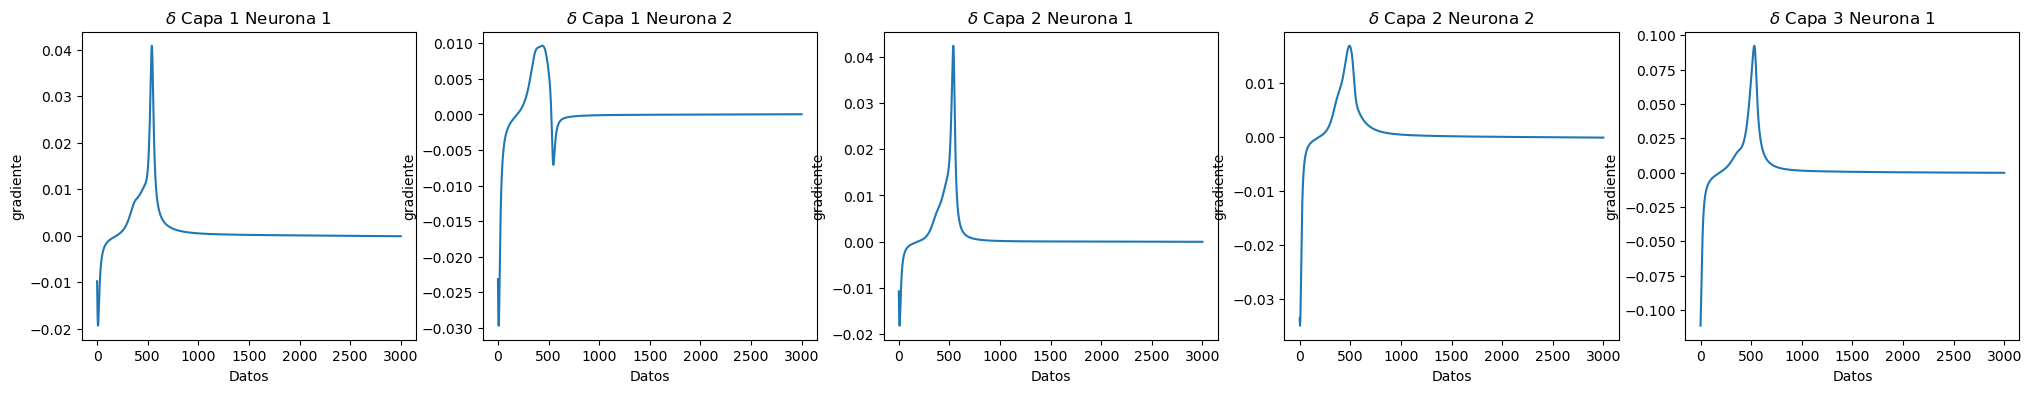

In [14]:
l3 = plot_gradiente(deltas,neuronas_por_capa)

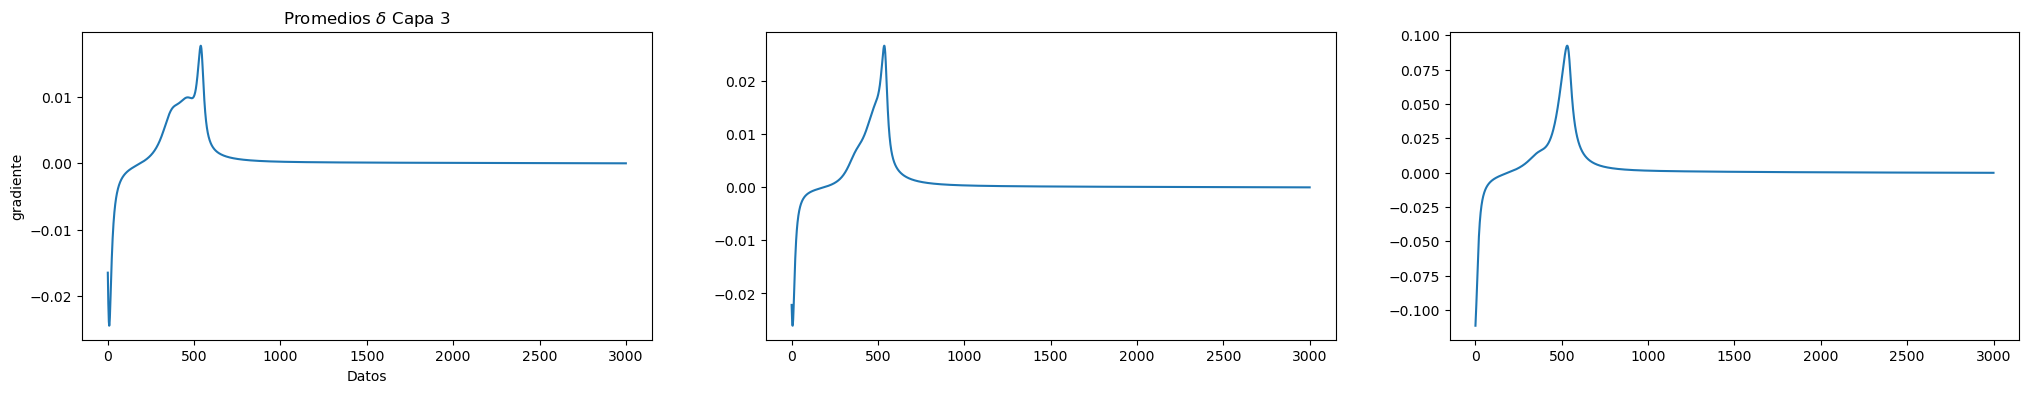

In [15]:
plotAverageDeltas(l3)

# Perceptrón dos capas ocultas ambas con dos neuronas

## Para $\eta=1$

Escenario 1: Datos originales

In [16]:
neuronas_por_capa = [len(data_combined[0,0:2]),2,2,1]
instance = MultilayerPerceptron(neuronas_por_capa,["lineal","tanh","tanh","sigmoid"])
pesos, deltas= instance.epochs(data_combined[:,[0,1]],data_combined[:,2],1,1)

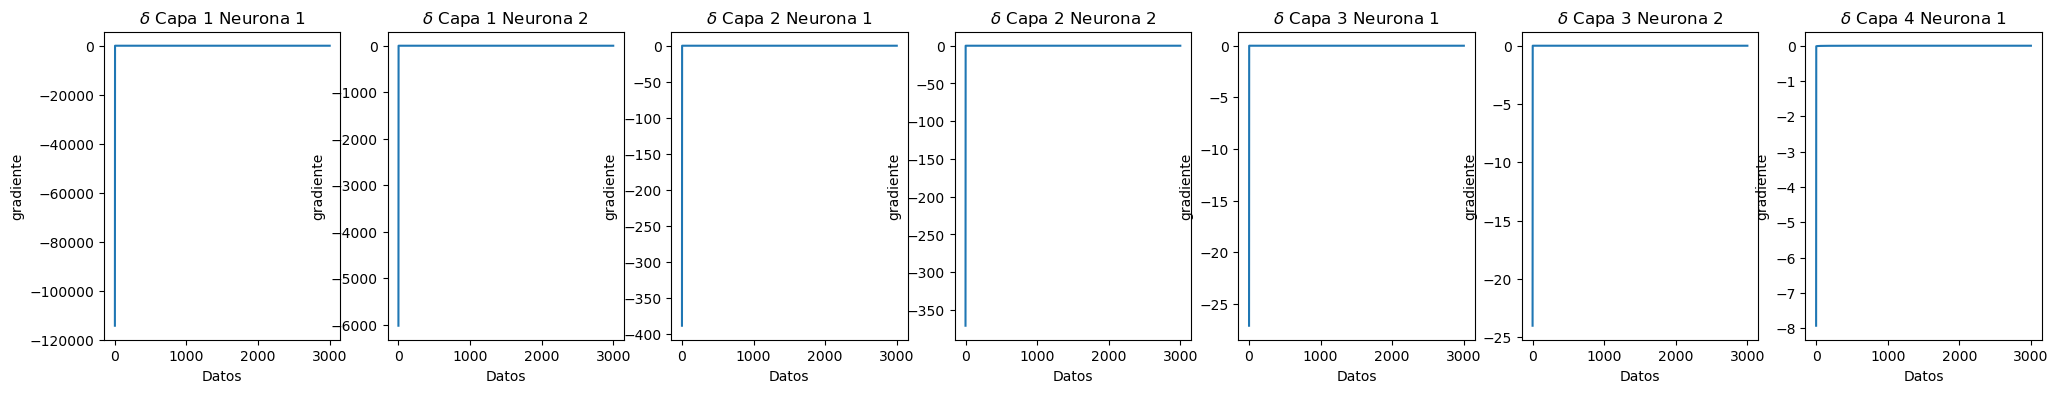

In [17]:
l3 = plot_gradiente(deltas,neuronas_por_capa)

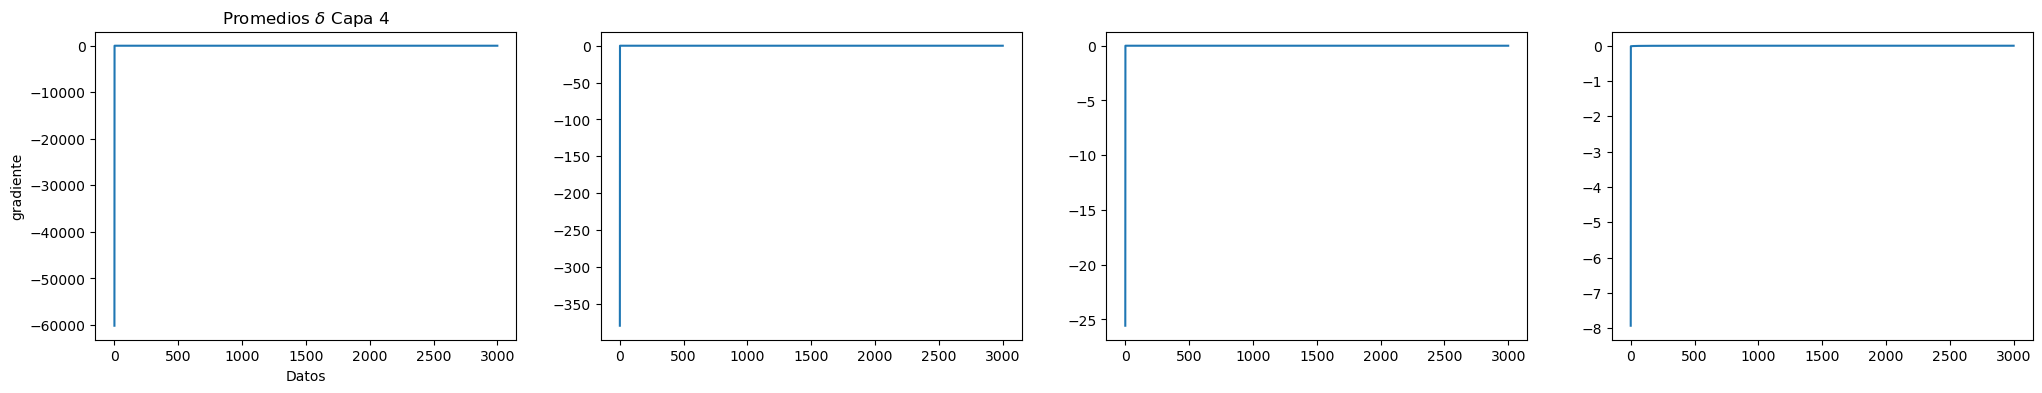

In [18]:
plotAverageDeltas(l3)

Escenario 2: Datos normalizados

In [19]:
neuronas_por_capa = [len(data_combined[0,0:2]),2,2,1]
instance = MultilayerPerceptron(neuronas_por_capa,["lineal","tanh","tanh","sigmoid"])
pesos, deltas= instance.epochs(normalized_data[:,[0,1]],normalized_data[:,2],1,1)

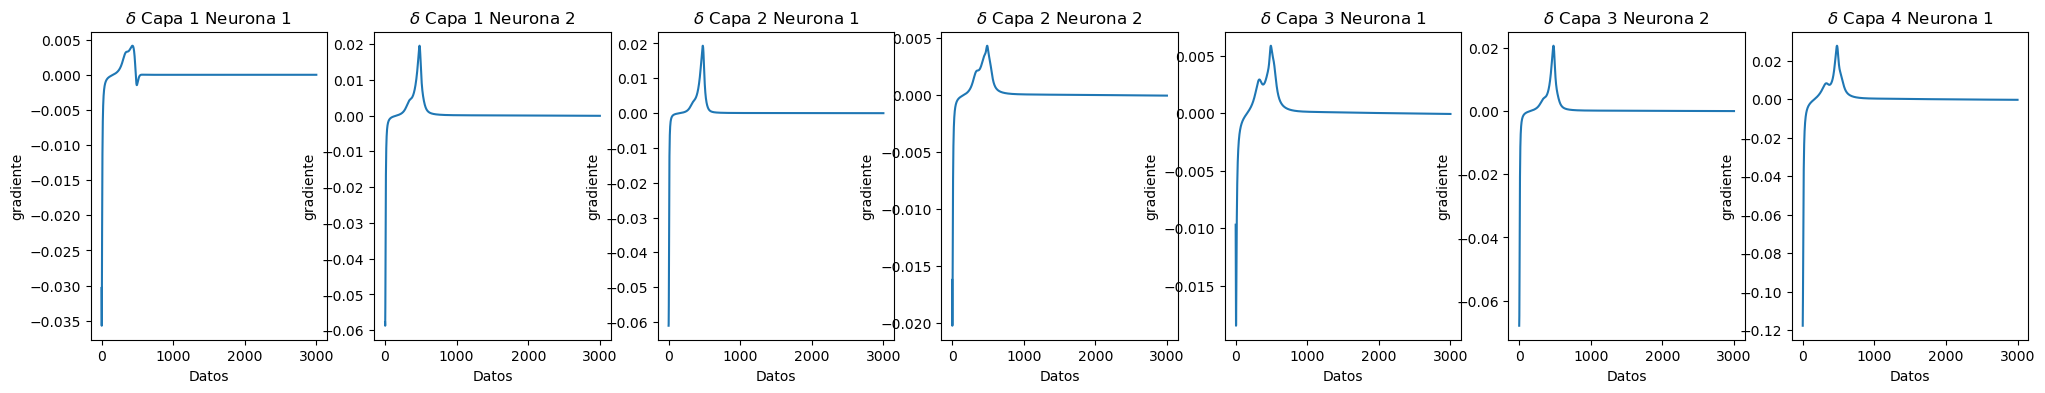

In [20]:
l3 = plot_gradiente(deltas,neuronas_por_capa)

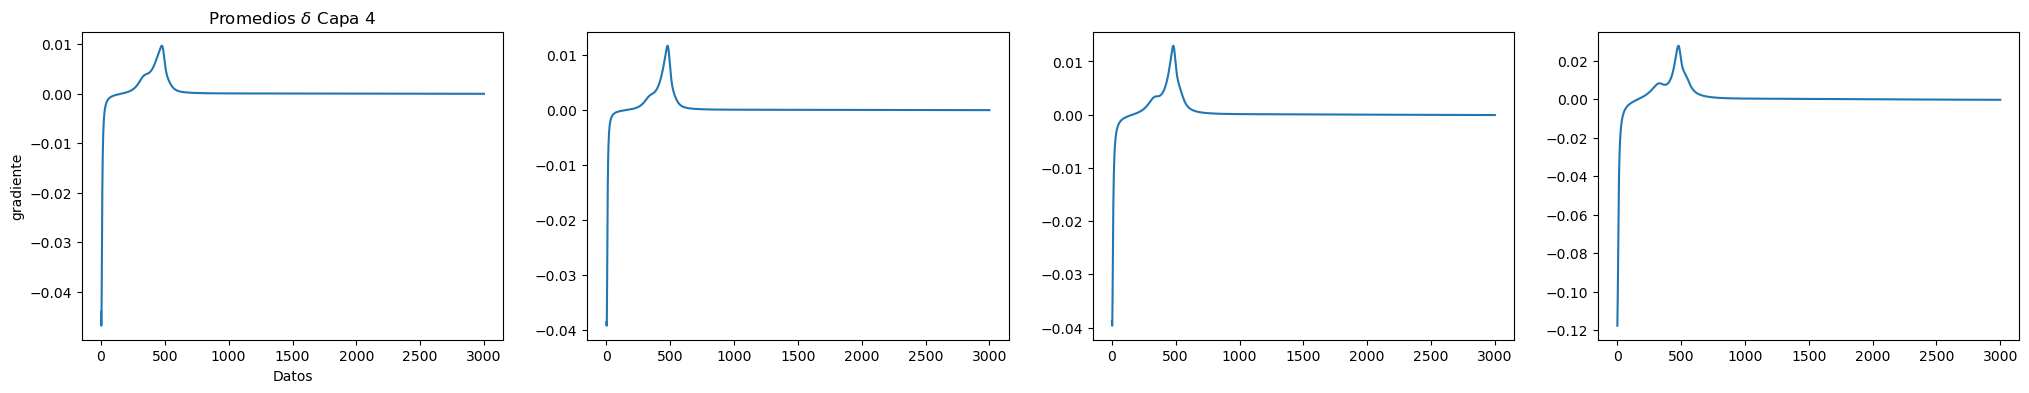

In [21]:
plotAverageDeltas(l3)

## Para $\eta=0.5$

Escenario 1: Datos originales

In [22]:
neuronas_por_capa = [len(data_combined[0,0:2]),2,2,1]
instance = MultilayerPerceptron(neuronas_por_capa,["lineal","tanh","tanh","sigmoid"])
pesos, deltas= instance.epochs(data_combined[:,[0,1]],data_combined[:,2],0.5,1)

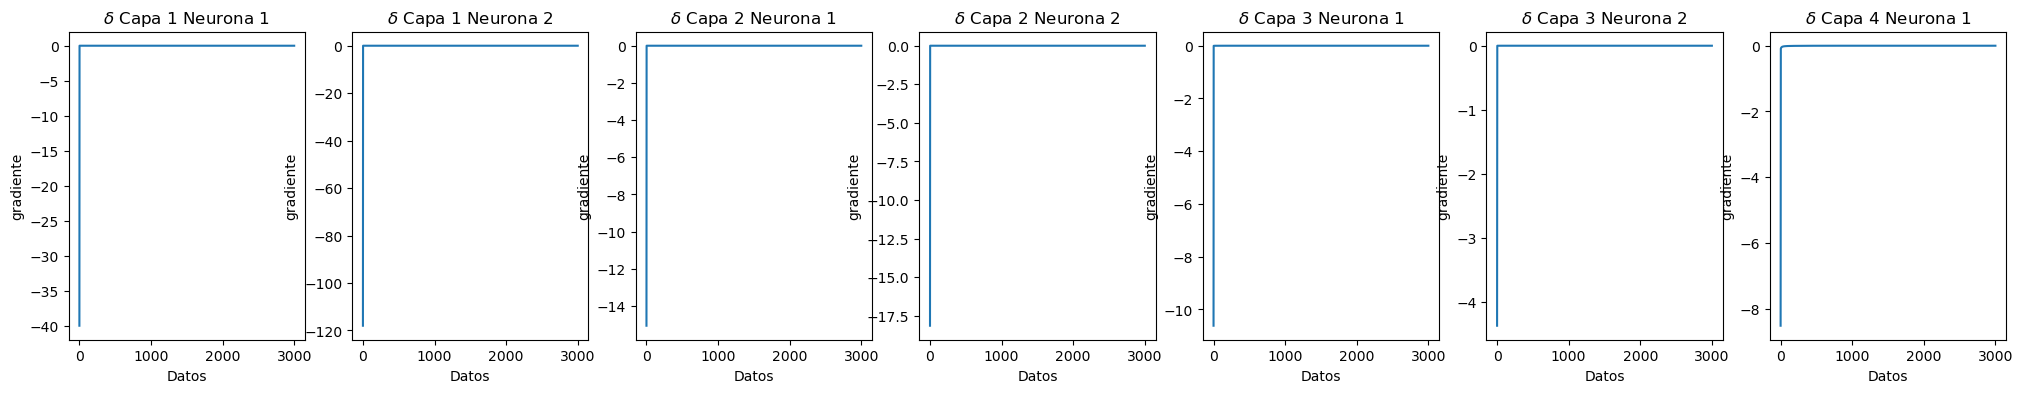

In [23]:
l3 = plot_gradiente(deltas,neuronas_por_capa)

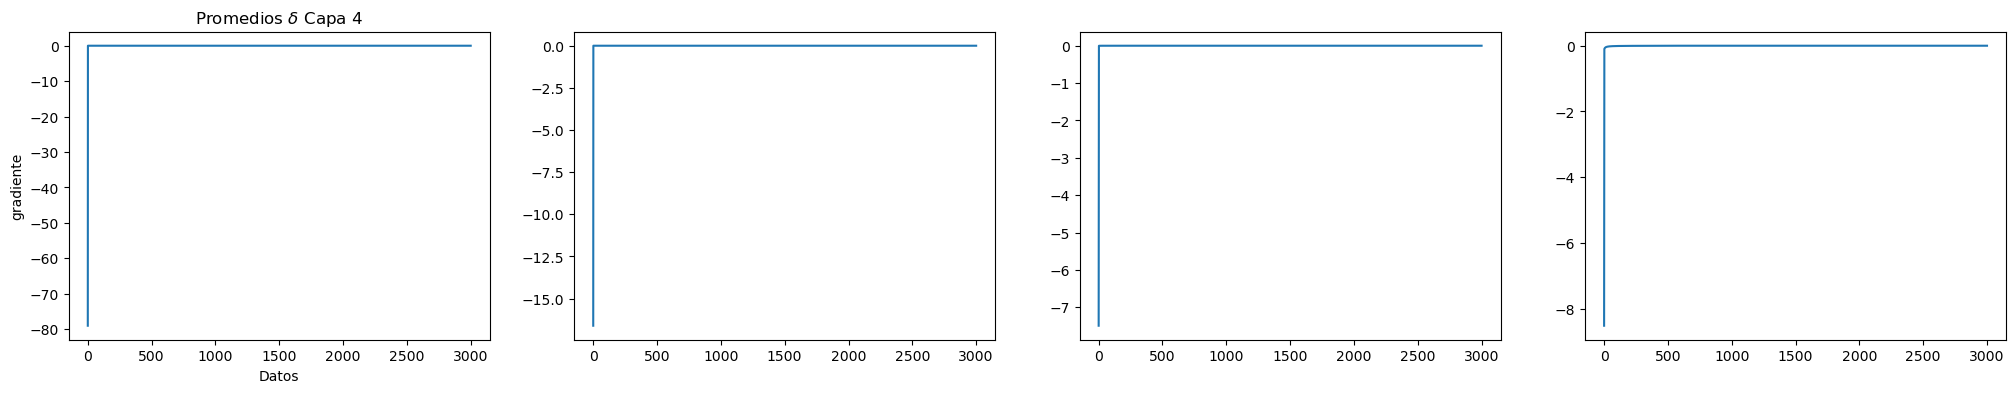

In [24]:
plotAverageDeltas(l3)

Escenario 2: Datos normalizados

In [25]:
neuronas_por_capa = [len(data_combined[0,0:2]),2,2,1]
instance = MultilayerPerceptron(neuronas_por_capa,["lineal","tanh","tanh","sigmoid"])
pesos, deltas= instance.epochs(normalized_data[:,[0,1]],normalized_data[:,2],0.5,1)

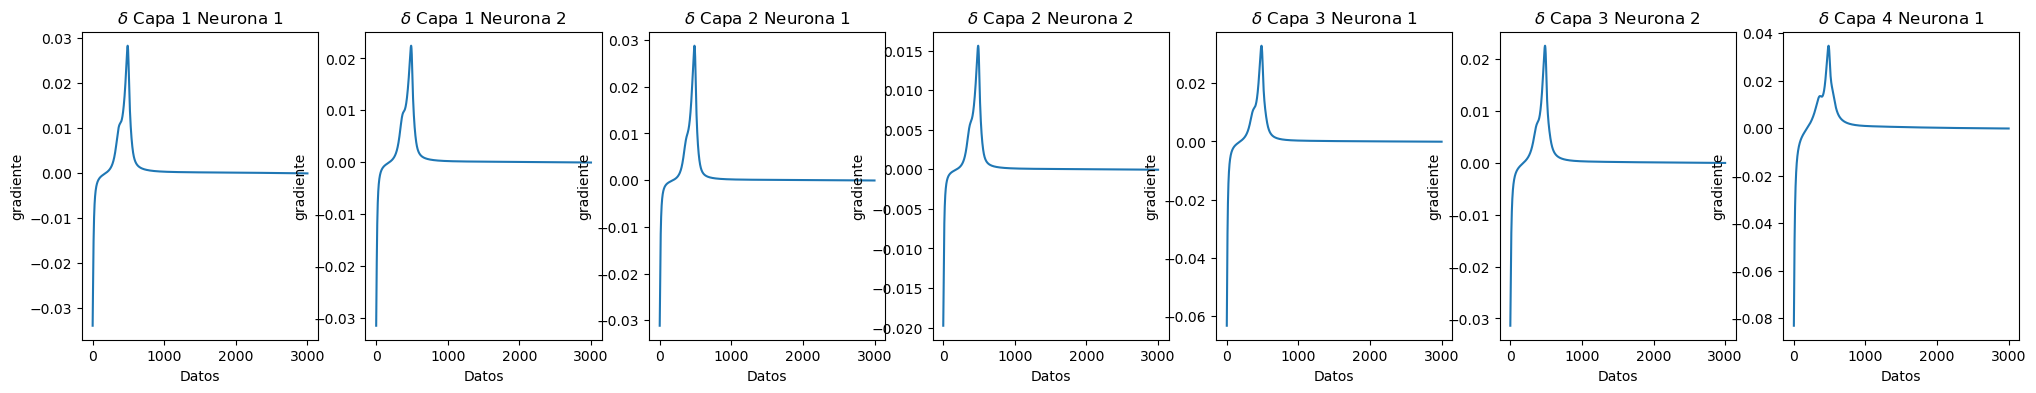

In [26]:
l3 = plot_gradiente(deltas,neuronas_por_capa)

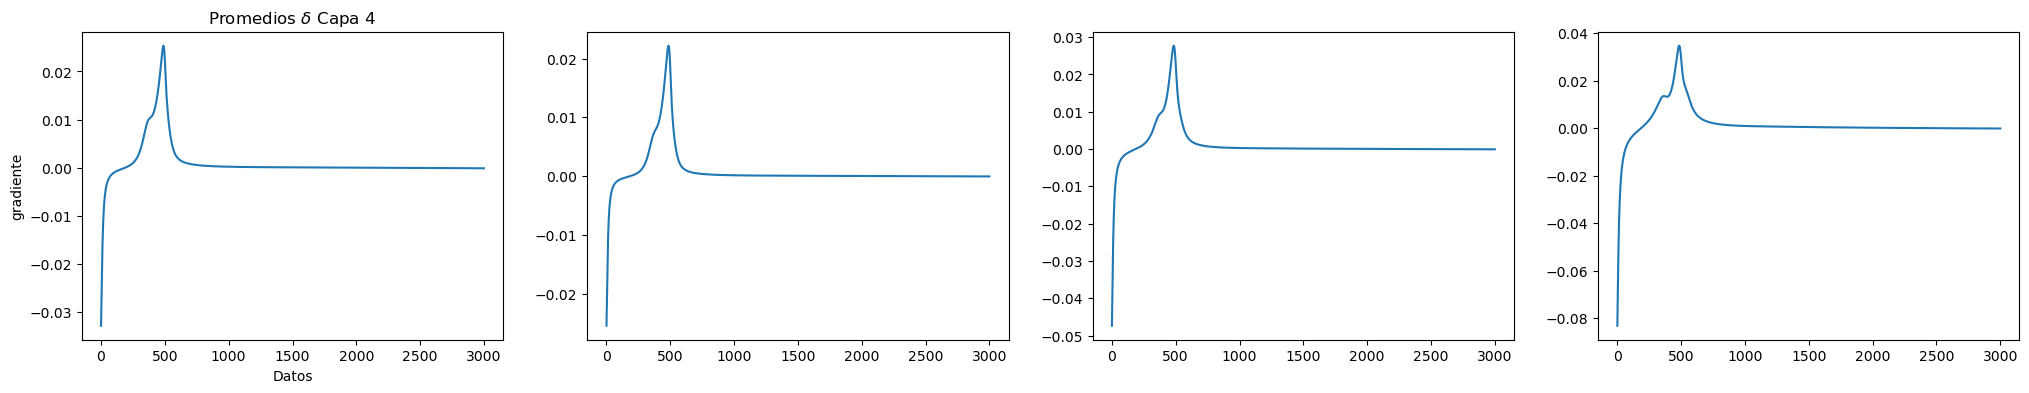

In [27]:
plotAverageDeltas(l3)